In [2]:

# Importación de librerías necesarias para el procesamiento de datos y análisis
from matplotlib import pyplot as plt
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import lime
import lime.lime_tabular
from sklearn.calibration import CalibratedClassifierCV
import os
import joblib
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
import sklearn
from sklearn.inspection import PartialDependenceDisplay
from sklearn.ensemble import RandomForestClassifier
import shap
from sklearn.calibration import LabelEncoder
import seaborn as sns
from sklearn.metrics import roc_curve, auc,accuracy_score, precision_score, recall_score, f1_score
import lightgbm as lgb
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.cluster import KMeans
from lightgbm import LGBMClassifier

C:\Users\Javier\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
## CARGA DE MODELOS

def cargar_datos():
    # Verificar si los archivos con los datos ya existen
    
    if os.path.exists('datos_X_PortScan.csv') and os.path.exists('datos_Y_PortScan.csv'):
        X = pd.read_csv('datos_X_PortScan.csv')
       # y = pd.read_csv('datos_y.csv', header=None, squeeze=True)  # Usar squeeze=True para obtener una Serie
        y = pd.read_csv('datos_Y_PortScan.csv', header=None, skiprows=1).iloc[:, 0]  # Obtener la Serie de una sola columna
    else:
        # Recopilación de archivos CSV de un directorio y concatenación en un DataFrame
        csv_files = []
        for dirname, _, filenames in os.walk('dataset\MachineLearningCSV_reducido\MachineLearningCVE-PortScan'):
            for filename in filenames:
                csv_file = os.path.join(dirname, filename)
                print(os.path.join(dirname, filename))
                csv_files.append(csv_file)
        df = pd.concat([pd.read_csv(file) for file in csv_files], ignore_index=True)

        # Limpieza de datos: eliminación de espacios en nombres de columnas y valores nulos o infinitos
        df.columns = df.columns.str.strip()
        df.replace([np.inf, -np.inf], np.nan, inplace=True)
        df.dropna(inplace=True)

        # Preprocesamiento de la columna 'Label' para agrupar categorías de ataques similares
        df_experiment = df.copy(deep=True)
        df_experiment.Label.replace("Web.*", "Web Attack", regex=True, inplace=True)
        df_experiment.Label.replace(r'.*Patator$', "Brute Force", regex=True,inplace=True)
        df_experiment.Label.replace(["DoS GoldenEye", "DoS Hulk", "DoS Slowhttptest", "DoS slowloris"], "DoS", inplace=True)

        # División de los datos en conjuntos de entrenamiento y prueba
        y = df_experiment.Label
        X = df_experiment.drop(columns='Label')

        # Guardar los datos en archivos CSV
        X.to_csv('datos_X_PortScan.csv', index=False)
        y.to_csv('datos_Y_PortScan.csv', index=False)

    return X, y

# Definir una función para realizar validación cruzada y obtener métricas de rendimiento
def cross_validate_model(model, X, y,model_name,cv=5):
    try: 
        scores = joblib.load(f'{model_name}_cross_val_results.pkl')      
    except FileNotFoundError:
        scores = cross_val_score(model, X, y, cv=cv)
        joblib.dump(scores,f'{model_name}_cross_val_results.pkl')

    print("Puntuaciones de validación cruzada:", scores)
    print("Media de puntuaciones:", scores.mean())
    print("Desviación estándar de puntuaciones:", scores.std())

def evaluate_model(model, X_test, y_test, X_selected, y, model_name):
    # Realizar predicciones y calcular la puntuación del modelo
    try: 
        score = joblib.load(f'{model_name}_score.pkl')
    except FileNotFoundError:
        score = model.score(X_test, y_test)
        joblib.dump(score,f'{model_name}_score.pkl')

    print(f"Puntuación del {model_name}: {score}") 
    print(f"Validación cruzada para {model_name}:")
    cross_validate_model(model, X_selected, y, model_name)
    mostrar_ejemplos_predicciones(model, model_name, X_test, y_test)
   
def test_svm_models(X_train, X_test, y_train, y_test, kernel, degree=0):

    if kernel == 'poly':
        svm_model = SVC(kernel=kernel, degree=degree)
        svm_model.fit(X_train, y_train)
        joblib.dump(svm_model, f'svm_model_{kernel}_degree_{degree}PortScan.pkl')
        score = svm_model.score(X_test, y_test)
        print(f"Score del SVM con kernel {kernel}: {score:.4f}: ")
    else:
        svm_model = SVC(kernel=kernel)
        svm_model.fit(X_train, y_train)
        joblib.dump(svm_model, f'svm_model_{kernel}PortScan.pkl')
        score = svm_model.score(X_test, y_test)
        print(f"Score del SVM con kernel {kernel}: {score:.4f}: ")

# Función para mostrar ejemplos de predicciones
def mostrar_ejemplos_predicciones(modelo, modelo_name,X_test, y_test, num_ejemplos=5):
    predicciones = modelo.predict(X_test)
    print("\nMatriz de confusión del modelo: "+f'{modelo_name}')
    print(confusion_matrix(y_test, predicciones))
    print("\nInforme de clasificación del modelo: "+f'{modelo_name}')
    print(classification_report(y_test, predicciones))

    # print("Ejemplos de predicciones:")
    # for i in range(num_ejemplos):
    #     ejemplo_prediccion = f"Ejemplo {i+1}: Predicción={predicciones[i]}, Verdadero={y_test.iloc[i]}"
    #     print(ejemplo_prediccion)

# Función para graficar la curva ROC de todos los modelos
def plot_roc_curves(models, X_test, y_test, y_test_encoded):
    plt.figure(figsize=(10, 8))
    for model_name, model in models.items():
        if hasattr(model, "predict_proba"):
            y_score = model.predict_proba(X_test)[:, 1]
        else:
            y_score = model.decision_function(X_test)
        fpr, tpr, _ = roc_curve(y_test_encoded, y_score)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2, label=f'{model_name} (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

In [5]:
## CARGA DE DATOS

X,y = cargar_datos()


try: 
    X_scaled = joblib.load('X_scaled.pkl')
    top_20_feature_names = joblib.load('top_20_feature_names.pkl')
except FileNotFoundError:
    indices = joblib.load('indices.pkl')
    top_20_feature_indices = indices[:20]  # Índices de las 20 características más importantes
    top_20_feature_names = X.columns[top_20_feature_indices].tolist() # Nombres de las 20 características más importantes
    joblib.dump(top_20_feature_names,'top_20_feature_names.pkl')
    X_selected = X.values[:, indices[:20]]  # Seleccionar las 20 características más importantes
    # Normalizar los datos
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_selected)
    joblib.dump(X_scaled,'X_scaled.pkl')

try: 
    X_train = joblib.load('X_train.pkl')
    X_test = joblib.load('X_test.pkl')
    y_train = joblib.load('y_train.pkl')
    y_test = joblib.load('y_test.pkl')
    X_train_df = pd.DataFrame(X_train, columns=top_20_feature_names)
    X_test_df = pd.DataFrame(X_test, columns=top_20_feature_names)

except FileNotFoundError:
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)
    joblib.dump(X_train,'X_train.pkl')
    joblib.dump(X_test,'X_test.pkl')
    joblib.dump(y_train,'y_train.pkl')
    joblib.dump(y_test,'y_test.pkl')

try:
    randomForest_modelPortScan = joblib.load('randomForest_model_PortScan.pkl')
except FileNotFoundError:
    randomForest_modelDDOS = RandomForestClassifier()
    randomForest_modelDDOS.fit(X_train, y_train)
    joblib.dump(randomForest_modelDDOS, 'randomForest_model_PortScan.pkl')

try:
    svm_model_linearPortScan = joblib.load('svm_model_linearPortScan.pkl')
except FileNotFoundError:
    test_svm_models(X_train, X_test, y_train, y_test, "linear")

try:
    svm_model_poly_degree_2PortScan = joblib.load('svm_model_poly_degree_2PortScan.pkl')
except FileNotFoundError:
    test_svm_models(X_train, X_test, y_train, y_test, "poly", 2)

try:
    svm_model_poly_degree_3PortScan = joblib.load('svm_model_poly_degree_3PortScan.pkl')
except FileNotFoundError:
    test_svm_models(X_train, X_test, y_train, y_test, "poly", 3)

try:
    svm_model_rbfPortScan = joblib.load('svm_model_rbfPortScan.pkl')
except FileNotFoundError:
    test_svm_models(X_train, X_test, y_train, y_test, "rbf")

try: 
    lgb_model_PortScan = joblib.load('lgb_model_PortScan.pkl')
except FileNotFoundError:
    lgb_model = lgb.LGBMClassifier(verbosity=-1)
    lgb_model.fit(X_train, y_train)
    joblib.dump(lgb_model, 'lgb_model_PortScan.pkl')

try: 
    label_encoder = LabelEncoder()
    y_train_encoded = label_encoder.fit_transform(y_train)
    y_test_encoded = label_encoder.transform(y_test)
    y_encoded = label_encoder.transform(y)
    y_test_encoded_series = pd.Series(y_test_encoded)
    xgBoost_model_PortScan = joblib.load('xgBoost_model_PortScan.pkl')
    #evaluate_model(xgBoost_model_DDOS, X_test, y_test_encoded_series, X_scaled, y_encoded, "xgBoost")
except FileNotFoundError:
    label_encoder = LabelEncoder()
    y_train_encoded = label_encoder.fit_transform(y_train)
    y_test_encoded = label_encoder.transform(y_test)
    xgBoost_model = xgb.XGBClassifier()
    xgBoost_model.fit(X_train, y_train_encoded)
    joblib.dump(xgBoost_model, 'xgBoost_model_PortScan.pkl')

try: 
    logisticRegression_model_PortScan = joblib.load('logisticRegression_model_PortScan.pkl')
    #evaluate_model(logisticRegression_model_DDOS, X_test, y_test, X_scaled, y, "logistic")
except FileNotFoundError:
    # Entrenamiento del modelo
    logistic_model = LogisticRegression(penalty='l2', solver='saga', max_iter=10000)
    logistic_model.fit(X_train, y_train)
    joblib.dump(logistic_model, 'logisticRegression_model_PortScan.pkl')

try: 
    mlp_model_PortScan = joblib.load('mlp_model_PortScan.pkl')
    #evaluate_model(mlp_model_DDOS,X_test,y_test,X_scaled,y,"mlp_model")
except FileNotFoundError:
    mlp_model = MLPClassifier(hidden_layer_sizes=(100,), max_iter=300, solver='adam', random_state=42)
    mlp_model.fit(X_train,y_train)
    joblib.dump(mlp_model,'mlp_model_PortScan.pkl')


In [4]:
# Carga de modelos calibrados
# Importante para los SVM hay que calibrarlos con CalibratedClassifierCV
# para habilitar la predicción de probabilidades (predict_proba), Aunque establecer probability=True permite 
# la estimación de probabilidades, puedes mejorar la calidad de estas probabilidades calibrando el modelo con 
# CalibratedClassifierCV.

try:
    calibrated_svmLineal = joblib.load('calibrated_svmLineal')
except FileNotFoundError:
    calibrated_svmLineal = CalibratedClassifierCV(svm_model_linearPortScan, method='sigmoid',cv='prefit')
    calibrated_svmLineal.fit(X_train, y_train)
    joblib.dump(calibrated_svmLineal, 'calibrated_svmLineal')
    print('svmLineal')

try:
    calibrated_svmPoly2 = joblib.load('calibrated_svmPoly2')
except FileNotFoundError:
    calibrated_svmPoly2 = CalibratedClassifierCV(svm_model_poly_degree_2PortScan, method='sigmoid',cv='prefit')
    calibrated_svmPoly2.fit(X_train, y_train)
    joblib.dump(calibrated_svmPoly2, 'calibrated_svmPoly2')
    print('poly2')

try:
    calibrated_svmPoly3 = joblib.load('calibrated_svmPoly3')
except FileNotFoundError:
    calibrated_svmPoly3 = CalibratedClassifierCV(svm_model_poly_degree_3PortScan, method='sigmoid',cv='prefit')
    calibrated_svmPoly3.fit(X_train, y_train)
    joblib.dump(calibrated_svmPoly3, 'calibrated_svmPoly3')
    print('poly3')

try:
    calibrated_svmRbf = joblib.load('calibrated_svmRbf')
except FileNotFoundError:
    calibrated_svmRbf = CalibratedClassifierCV(svm_model_rbfPortScan, method='sigmoid',cv='prefit')
    calibrated_svmRbf.fit(X_train, y_train)
    joblib.dump(calibrated_svmRbf, 'calibrated_svmRbf')
    print('svmRbf')

poly2
poly3
svmRbf


In [14]:
## EVALUACIONES DE ACCURACY Y VALIDACION CRUZADA
print("Etiquetas únicas y cantidad de clases:")
labels = y.unique()
classes = y.nunique()
print("labels:", labels) 
print("classes", classes)

# Evaluar cada modelo, precisión, puntuaciones de validación cruzada, su media y desviación estándar 
evaluate_model(randomForest_modelPortScan, X_test, y_test, X_scaled, y, "randomForest")
print("\n")
evaluate_model(logisticRegression_model_PortScan, X_test, y_test, X_scaled, y, "logisticRegression")
print("\n")
evaluate_model(mlp_model_PortScan, X_test, y_test, X_scaled, y, "mlp")
print("\n")
evaluate_model(lgb_model_PortScan, X_test, y_test, X_scaled, y, "lgb")
print("\n")
evaluate_model(xgBoost_model_PortScan, X_test, y_test_encoded_series, X_scaled, y_encoded, "xgBoost")
print("\n")
evaluate_model(svm_model_linearPortScan, X_test, y_test, X_scaled, y, "svmLineal")
print("\n")
evaluate_model(svm_model_poly_degree_2PortScan, X_test, y_test, X_scaled, y, "svmPoly2")
print("\n")
evaluate_model(svm_model_poly_degree_3PortScan, X_test, y_test, X_scaled, y, "svmPoly3")
print("\n")
evaluate_model(svm_model_rbfPortScan, X_test, y_test, X_scaled, y, "svmRbf")

models = {
    'Random Forest': randomForest_modelPortScan,
    'Logistic Regression': logisticRegression_model_PortScan,
    'MLP': mlp_model_PortScan,
    'LightGBM': lgb_model_PortScan,
    'XGBoost': xgBoost_model_PortScan,
    'SVM Linear': svm_model_linearPortScan,
    'SVM Poly Degree 2': svm_model_poly_degree_2PortScan,
    'SVM Poly Degree 3': svm_model_poly_degree_3PortScan,
    'SVM RBF': svm_model_rbfPortScan
}

# Descomentar para mostrar la curva ROC de todos los modelos, tarda 10 min aprox
# plot_roc_curves(models, X_test, y_test, y_test_encoded)

Etiquetas únicas y cantidad de clases:
labels: ['BENIGN' 'PortScan']
classes 2
Puntuación del randomForest: 0.9998776651520448
Validación cruzada para randomForest:
Puntuaciones de validación cruzada: [0.999633   0.99968542 0.99944075 0.99984271 0.99877663]
Media de puntuaciones: 0.9994756999143799
Desviación estándar de puntuaciones: 0.00037238166967308166

Matriz de confusión del modelo: randomForest
[[25455     4]
 [    3 31758]]

Informe de clasificación del modelo: randomForest
              precision    recall  f1-score   support

      BENIGN       1.00      1.00      1.00     25459
    PortScan       1.00      1.00      1.00     31761

    accuracy                           1.00     57220
   macro avg       1.00      1.00      1.00     57220
weighted avg       1.00      1.00      1.00     57220



Puntuación del logisticRegression: 0.9559245019224047
Validación cruzada para logisticRegression:
Puntuaciones de validación cruzada: [0.94694163 0.96212796 0.95178175 0.95705972 0.95

In [9]:
## EXPLICABILIDAD GLOBAL
#IMPORTANCIA DE CARACTERÍSTICAS CON COEFICIENTES DEL MODELO

# Obtener los coeficientes del modelo SVM lineal o Logistic Regression, solo funciona con los modelos que se 
# pueden ajustar linealmente, para ello llamar a la función (en la última celda) con el modelo y los nombres 
# de las 20 características. Ejemplos de como se llamaría con cada uno de los modelos:

# explicabilidad_global(logisticRegression_model_PortScan, top_20_feature_names)
# explicabilidad_global(svm_model_linearPortScan, top_20_feature_names)

# Function to display global feature importance
def explicabilidad_global(model, feature_names):
    try:
        coeficientes = model.coef_[0]
        importancias = np.abs(coeficientes)
    except AttributeError:
        print("Este modelo no proporciona coeficientes directamente.")
        return
    
    scaler = MinMaxScaler()
    importancias_normalizadas = scaler.fit_transform(importancias.reshape(-1, 1)).flatten()
    
    plt.bar(range(len(importancias_normalizadas)), importancias_normalizadas)
    plt.xticks(range(len(importancias_normalizadas)), feature_names, rotation='vertical')
    plt.xlabel('Características')
    plt.ylabel('Importancia')
    plt.title('Importancia de características del modelo')
    plt.tight_layout()
    plt.show()

In [4]:
## VALORES DE SHAP PARA CADA CARACTERÍSTICA DE MANERA GLOBAL
# Calcula los valores SHAP para todas las características e instancias, tiene problemas de rendimiento con el
# explicador KernelExplainer y con el DeepExplainer lo cual afecta a SVM poly 2 y 3, SVM Rbf y a MLP.
# Dejo de todas formas implementado como sería con poly 2 por si alguien quiere probar su rendimiento, quizás 
# sea por falta de recursos, para el resto de los mencionados sería replicar simplemente.

# Ejemplos de como se llamaría a la función con cada uno de los modelos para copiar y pegar en la última celda el
# que se quiera ejecutar:

# shap_valores_globales(calibrated_svmLineal, 'svmLineal', top_20_feature_names)
# shap_valores_globales(randomForest_modelPortScan, 'randomForest', top_20_feature_names)
# shap_valores_globales(lgb_model_PortScan, 'lgb', top_20_feature_names)
# shap_valores_globales(xgBoost_model_PortScan, 'xgBoost', top_20_feature_names)
# shap_valores_globales(logisticRegression_model_PortScan, 'logisticRegression', top_20_feature_names)
# shap_valores_globales(calibrated_svmPoly2, 'poly2', top_20_feature_names) #Problemas rendimiento KernelExplainer
# shap_valores_globales(mlp_model_PortScan, 'mlp', top_20_feature_names) #Problemas rendimiento DeepExplainer

def shap_valores_globales(model,modelName, feature_names, clase = 0):
    shap.initjs()
    if modelName == 'svmLineal':
        try: 
            shap_values = joblib.load('shap_values_svmLineal.pkl')
        except FileNotFoundError:
            explainer_shap_svmLineal = shap.LinearExplainer(model,X_train_df)
            joblib.dump(explainer_shap_svmLineal,'explainer_shap_svmLineal.pkl')
            shap_values = explainer_shap_svmLineal.shap_values(X_test_df)
            joblib.dump(shap_values,'shap_values_svmLineal.pkl')
        shap.summary_plot(shap_values, X_test, feature_names = feature_names)
    elif modelName == 'randomForest':
        try: 
            shap_values=joblib.load('shap_values_randomForest.pkl')
            shap_values_class0 = shap_values[:,:,clase]
            shap.summary_plot(shap_values_class0, X_test, feature_names = feature_names)
        except FileNotFoundError:
            explainer_shap_randomForest = shap.TreeExplainer(model,X_train_df)
            joblib.dump(explainer_shap_randomForest,'explainer_shap_randomForest.pkl')
            shap_values = explainer_shap_randomForest.shap_values(X_test_df)
            joblib.dump(shap_values,'shap_values_randomForest.pkl')
            shap_values_class0 = shap_values[:,:,clase]
            shap.summary_plot(shap_values_class0, X_test, feature_names = feature_names)
    elif modelName == 'lgb':
        try:
            shap_values = joblib.load('shap_values_lgb.pkl')
        except FileNotFoundError:
            explainer_shap_lgb = shap.TreeExplainer(model,X_train_df)
            joblib.dump(explainer_shap_lgb,'explainer_shap_lgb.pkl')
            shap_values = explainer_shap_lgb.shap_values(X_test_df)
            joblib.dump(shap_values,'shap_values_lgb.pkl')
        shap.summary_plot(shap_values, X_test, feature_names = feature_names)
    elif modelName == 'xgBoost':
        try: 
            shap_values = joblib.load('shap_values_xgBoost.pkl')
        except FileNotFoundError:
            explainer_shap_xgBoost = shap.TreeExplainer(model,X_train_df)
            joblib.dump(explainer_shap_xgBoost,'explainer_shap_xgBoost.pkl')
            shap_values = explainer_shap_xgBoost.shap_values(X_test_df)
            joblib.dump(shap_values,'shap_values_xgBoost.pkl')
        shap.summary_plot(shap_values, X_test, feature_names = feature_names)
    elif modelName == 'logisticRegression':
        try: 
            shap_values = joblib.load('shap_values_logisticRegression.pkl')
        except FileNotFoundError:
            explainer_shap_logisticRegression = shap.LinearExplainer(model,X_train_df)
            joblib.dump(explainer_shap_logisticRegression,'explainer_shap_logisticRegression.pkl')
            shap_values = explainer_shap_logisticRegression.shap_values(X_test_df)
            joblib.dump(shap_values,'shap_values_logisticRegression.pkl')    
        shap.summary_plot(shap_values, X_test, feature_names = feature_names)
    
    elif modelName == 'mlp':
        try: 
            shap_values = joblib.load('shap_values_mlp.pkl')
            shap.summary_plot(shap_values, X_test, feature_names = feature_names)
        except FileNotFoundError:
            explainer_shap_mlp = shap.DeepExplainer(model.predict_proba ,X_train_df) # si no lo soporta probar con KernelExplainer también
            joblib.dump(explainer_shap_mlp,'explainer_shap_mlp.pkl')
            shap_values = explainer_shap_mlp.shap_values(X_test_df)
            joblib.dump(shap_values,'shap_values_mlp.pkl')
            shap.summary_plot(shap_values, X_test, feature_names = feature_names)
        
    elif modelName == 'poly2':
        try: 
            shap_values = joblib.load('shap_values_poly2.pkl')
            shap.summary_plot(shap_values, X_test, feature_names = feature_names)
        except FileNotFoundError:
            explainer_shap_svmPoly2 = shap.KernelExplainer(model.predict_proba, shap.sample(X_train, 100))
            joblib.dump(explainer_shap_svmPoly2,'explainer_shap_poly2.pkl')
            # Calcular los valores SHAP para todas las muestras de datos
            shap_values = explainer_shap_svmPoly2.shap_values(X_test_df)
            joblib.dump(shap_values,'shap_values_poly2.pkl')
            # Mostrar un resumen de los valores SHAP
            shap.summary_plot(shap_values, X_test_df, plot_type="bar", feature_names=top_20_feature_names)
    else: 
        print("No se ha introducido un modelo válido")

In [5]:
## EXPLICACION LOCAL PARA INSTANCIAS CON SHAP
# Obtener una explicación interactiva para una muestra específica
# Function for SHAP local explanation

# IMPORTANTE haber ejecutado antes al menos una vez los valores SHAP y tener guardados los explicadores y valores SHAP.
# Llamar a la función con el modelo , conjunto de test, instancia y nombres de características)

# Ejemplos de como se llamaría a la función con cada uno de los modelos para copiar y pegar en la última celda el
# que se quiera ejecutar (con la instancia numero 1):

# shap_explicacion_local('xgBoost', X_test, 1, top_20_feature_names)
# shap_explicacion_local('randomForest', X_test, 1, top_20_feature_names)
# shap_explicacion_local('svmLineal', X_test, 1, top_20_feature_names)
# shap_explicacion_local('lgb', X_test, 1, top_20_feature_names)
# shap_explicacion_local('logisticRegression', X_test, 1, top_20_feature_names)
# shap_explicacion_local('mlp', X_test, 1, top_20_feature_names)
# shap_explicacion_local('poly2', X_test, 1, top_20_feature_names)


def shap_explicacion_local(explainerModelName, X_test, sample_index, feature_names):
    explainerModel = joblib.load(f'explainer_shap_{explainerModelName}.pkl')
    shap_values = joblib.load(f'shap_values_{explainerModelName}.pkl')
    shap.initjs()
    if explainerModelName == 'randomForest':
        shap.force_plot(explainerModel.expected_value[0], shap_values[sample_index,:,1], X_test[sample_index,:], feature_names=feature_names,matplotlib=True,figsize=(50, 2.5))
    elif explainerModelName == 'svmLineal' or explainerModelName == 'lgb' or explainerModelName == 'xgBoost' or explainerModelName == 'logisticRegression' or explainerModelName == 'mlp' or explainerModelName == 'poly2':
        expl = explainerModel.shap_values(X_test[sample_index])
        shap.force_plot(explainerModel.expected_value, expl, X_test[sample_index], feature_names = top_20_feature_names,matplotlib=True, figsize=(50, 2.5))
    else: 
        print("No se ha introducido un modelo válido")

In [6]:
## RELACION DE VALORES SHAP CON VALORES REALES
# Function for SHAP values vs real values

# IMPORTANTE haber ejecutado antes al menos una vez los valores SHAP y tener guardados los explicadores y valores SHAP.

# Ejemplos de como se llamaría a la función con cada uno de los modelos para copiar y pegar en la última celda el
# que se quiera ejecutar (con la característica 0 (van desde la 0-19)):

# shap_valores_vs_reales('xgBoost', X_test_df, top_20_feature_names, 0)
# shap_valores_vs_reales('lgb', X_test_df, top_20_feature_names, 0)
# shap_valores_vs_reales('svmLineal', X_test_df, top_20_feature_names, 0)
# shap_valores_vs_reales('randomForest', X_test_df, top_20_feature_names, 0, X) X puede ser 0 o 1 para la clase.
# shap_valores_vs_reales('logisticRegression', X_test_df, top_20_feature_names, 0)
# shap_valores_vs_reales('mlp', X_test_df, top_20_feature_names, 0)
# shap_valores_vs_reales('poly2', X_test_df, top_20_feature_names, 0)


def shap_valores_vs_reales(explainerModelName, X_test, feature_names, feature_index, clase=0):
   if explainerModelName == 'randomForest':
       # Choose an interaction index that is different from the feature index 
        shap_values = joblib.load(f'shap_values_{explainerModelName}.pkl')
        shap.dependence_plot(feature_index, shap_values[:,:,0], X_test, feature_names=feature_names,interaction_index=feature_names[feature_index])
   elif explainerModelName == 'svmLineal' or explainerModelName =='lgb' or explainerModelName == 'xgBoost' or explainerModelName == 'logisticRegression' or explainerModelName == 'mlp' or explainerModelName == 'poly2':
       # Choose an interaction index that is different from the feature index 
        shap_values = joblib.load(f'shap_values_{explainerModelName}.pkl')
        shap.dependence_plot(feature_index, shap_values, X_test, feature_names=feature_names,interaction_index=feature_names[feature_index])
   else: 
        print("No se ha introducido un modelo válido")

In [4]:
## ANALISIS DE IMPORTANCIA DE CARACTERÍSTICAS PARA INSTANCIAS CONCRETAS CON LIME (GRAFICO DISPERSION)
# Obtener las características y sus pesos

# Obtener las características y sus pesos

# IMPORTANTE tener los modelos calibrados cargados y guardados.

# Ejemplos de como se llamaría a la función con cada uno de los modelos para copiar y pegar en la última celda el
# que se quiera ejecutar (para la instancia 2):

# lime_analisis_caracteristicasDispersion('logisticRegression', X_train, X_test, 2, top_20_feature_names)
# lime_analisis_caracteristicasDispersion('randomForest', X_train, X_test, 2, top_20_feature_names)
# lime_analisis_caracteristicasDispersion('lgb', X_train, X_test, 2, top_20_feature_names)
# lime_analisis_caracteristicasDispersion('xgBoost', X_train, X_test, 2, top_20_feature_names)
# lime_analisis_caracteristicasDispersion('mlp', X_train, X_test, 2, top_20_feature_names)
# lime_analisis_caracteristicasDispersion('svmLineal', X_train, X_test, 2, top_20_feature_names)
# lime_analisis_caracteristicasDispersion('svmPoly2', X_train, X_test, 2, top_20_feature_names)
# lime_analisis_caracteristicasDispersion('svmPoly3', X_train, X_test, 2, top_20_feature_names)
# lime_analisis_caracteristicasDispersion('svmRbf', X_train, X_test, 2, top_20_feature_names)


def lime_analisis_caracteristicasDispersion(model,modelName, X_train, X_test, sample_index, feature_names):
    if modelName == 'svmLineal' or modelName == 'svmPoly2' or modelName == 'svmPoly3' or modelName == 'svmRbf':
        try: 
            calibrated = joblib.load('calibrated_'f'{modelName}')
        except FileNotFoundError:
            calibrated = CalibratedClassifierCV(model, method='sigmoid', cv='prefit')
            calibrated.fit(X_train, y_train)
            joblib.dump(calibrated, 'calibrated_'f'{modelName}')
    elif modelName == 'randomForest':
        calibrated = randomForest_modelPortScan
    elif modelName == 'lgb':
        calibrated = lgb_model_PortScan
    elif modelName == 'xgBoost':
        calibrated = xgBoost_model_PortScan
    elif modelName == 'logisticRegression':
        calibrated = logisticRegression_model_PortScan
    elif modelName == 'mlp':
        calibrated = mlp_model_PortScan
    else :
        print("No se ha introducido un modelo válido")

    explainer_lime = lime.lime_tabular.LimeTabularExplainer(X_train, feature_names=feature_names, class_names=['BENIGN', 'PortScan'], discretize_continuous=True)
    expLime = explainer_lime.explain_instance(X_test[sample_index], calibrated.predict_proba)
    weights = expLime.as_list()
    feature_importance = {feat: weight for feat, weight in weights}
    # Obtener las características y sus pesos
    features = list(feature_importance.keys())
    weights = list(feature_importance.values())

    # Crear un gráfico de dispersión
    plt.figure(figsize=(8, 6))
    plt.scatter(weights, features, color='green', alpha=0.5)
    plt.xlabel('Peso')
    plt.ylabel('Característica')
    plt.title('Importancia de las características según LIME')
    plt.grid(True)
    plt.show()


In [6]:
## ANALISIS DE IMPORTANCIA DE CARACTERÍSTICAS PARA INSTANCIAS CONCRETAS CON LIME 
# Obtener las características y sus pesos

# IMPORTANTE tener los modelos calibrados cargados y guardados.

# Ejemplos de como se llamaría a la función con cada uno de los modelos para copiar y pegar en la última celda el
# que se quiera ejecutar (para la instancia 2):

# lime_analisis_caracteristicas('logisticRegression', X_train, X_test, 2, top_20_feature_names)
# lime_analisis_caracteristicas('randomForest', X_train, X_test, 2, top_20_feature_names)
# lime_analisis_caracteristicas('lgb', X_train, X_test, 2, top_20_feature_names)
# lime_analisis_caracteristicas('xgBoost', X_train, X_test, 2, top_20_feature_names)
# lime_analisis_caracteristicas('mlp', X_train, X_test, 2, top_20_feature_names)
# lime_analisis_caracteristicas('svmLineal', X_train, X_test, 2, top_20_feature_names)
# lime_analisis_caracteristicas('svmPoly2', X_train, X_test, 2, top_20_feature_names)
# lime_analisis_caracteristicas('svmPoly3', X_train, X_test, 2, top_20_feature_names)
# lime_analisis_caracteristicas('svmRbf', X_train, X_test, 2, top_20_feature_names)


def lime_analisis_caracteristicas(model,modelName, X_train, X_test, sample_index, feature_names):
    if modelName == 'svmLineal' or modelName == 'svmPoly2' or modelName == 'svmPoly3' or modelName == 'svmRbf':
        try: 
            calibrated = joblib.load('calibrated_'f'{modelName}')
        except FileNotFoundError:
            calibrated = CalibratedClassifierCV(model, method='sigmoid', cv='prefit')
            calibrated.fit(X_train, y_train)
            joblib.dump(calibrated, 'calibrated_'f'{modelName}')
    elif modelName == 'randomForest':
        calibrated = randomForest_modelPortScan
    elif modelName == 'lgb':
        calibrated = lgb_model_PortScan
    elif modelName == 'xgBoost':
        calibrated = xgBoost_model_PortScan
    elif modelName == 'logisticRegression':
        calibrated = logisticRegression_model_PortScan
    elif modelName == 'mlp':
        calibrated = mlp_model_PortScan
    else :
        print("No se ha introducido un modelo válido")
        
    explainer_lime = lime.lime_tabular.LimeTabularExplainer(X_train, feature_names=feature_names, class_names=['BENIGN', 'PortScan'], discretize_continuous=True)
    expLime = explainer_lime.explain_instance(X_test[sample_index], calibrated.predict_proba)
    weights = expLime.as_list()
    feature_importance = {feat: weight for feat, weight in weights}
    # Obtener las características y sus pesos
    features = list(feature_importance.keys())
    weights = list(feature_importance.values())

    # Crear un gráfico de barras
    plt.figure(figsize=(10, 6))
    plt.barh(features, weights, color='skyblue')
    plt.xlabel('Peso')
    plt.ylabel('Característica')
    plt.title('Importancia de las características según LIME')
    plt.show()


In [8]:
## EXPLICACION LOCAL PARA INSTANCIAS CON LIME
# Function for LIME analysis for specific instances

# IMPORTANTE tener los modelos calibrados cargados y guardados.

# Ejemplos de como se llamaría a la función con cada uno de los modelos para copiar y pegar en la última celda el
# que se quiera ejecutar (para la instancia 2):

# lime_analisis_instancias('logisticRegression', X_train, X_test, 2, top_20_feature_names)
# lime_analisis_instancias('randomForest', X_train, X_test, 2, top_20_feature_names)
# lime_analisis_instancias('lgb', X_train, X_test, 2, top_20_feature_names)
# lime_analisis_instancias('xgBoost', X_train, X_test, 2, top_20_feature_names)
# lime_analisis_instancias('mlp', X_train, X_test, 2, top_20_feature_names)
# lime_analisis_instancias('svmLineal', X_train, X_test, 2, top_20_feature_names)
# lime_analisis_instancias('svmPoly2', X_train, X_test, 2, top_20_feature_names)
# lime_analisis_instancias('svmPoly3', X_train, X_test, 2, top_20_feature_names)
# lime_analisis_instancias('svmRbf', X_train, X_test, 2, top_20_feature_names)


def lime_analisis_instancias(model,modelName, X_train, X_test, sample_index, feature_names):
    if modelName == 'svmLineal' or modelName == 'svmPoly2' or modelName == 'svmPoly3' or modelName == 'svmRbf':
        try: 
            calibrated = joblib.load('calibrated_'f'{modelName}')
        except FileNotFoundError:
            calibrated = CalibratedClassifierCV(model, method='sigmoid', cv='prefit')
            calibrated.fit(X_train, y_train)
            joblib.dump(calibrated, 'calibrated_'f'{modelName}')
    elif modelName == 'randomForest':
        calibrated = randomForest_modelPortScan
    elif modelName == 'lgb':
        calibrated = lgb_model_PortScan
    elif modelName == 'xgBoost':
        calibrated = xgBoost_model_PortScan
    elif modelName == 'logisticRegression':
        calibrated = logisticRegression_model_PortScan
    elif modelName == 'mlp':
        calibrated = mlp_model_PortScan
    else :
        print("No se ha introducido un modelo válido")
        
    explainer_lime = lime.lime_tabular.LimeTabularExplainer(X_train, feature_names=feature_names, class_names=['BENIGN', 'PortScan'], discretize_continuous=True)
    exp = explainer_lime.explain_instance(X_test[sample_index], calibrated.predict_proba)
    exp.show_in_notebook(show_table=True)


In [15]:
## ANALISIS DE RESIDUOS
# Los residuos on la diferencia entre los valores reales y los valores predichos por el modelo
# IMPORTANTE tener los modelos calibrados cargados y guardados.

# Ejemplos de como se llamaría a la función con cada uno de los modelos para copiar y pegar en la última celda el
# que se quiera ejecutar:

# analisis_residuos('xgBoost', X_test, y_test)
# analisis_residuos('randomForest', X_test, y_test)
# analisis_residuos('mlp', X_test, y_test)
# analisis_residuos('lgb', X_test, y_test)
# analisis_residuos('logisticRegression', X_test, y_test)
# analisis_residuos('svmLineal', X_test, y_test)
# analisis_residuos('svmPoly2', X_test, y_test)
# analisis_residuos('svmPoly3', X_test, y_test)
# analisis_residuos('svmRbf', X_test, y_test)

def analisis_residuos(modelName,X_test,y_test):
    # Copiar y_test para no modificar los datos originales

    y_test_encoded = y_test.copy()

    # Inicializar el codificador de etiquetas
    label_encoder = LabelEncoder()

    # Ajustar el codificador de etiquetas y transformar las etiquetas
    y_test_encoded = label_encoder.fit_transform(y_test_encoded)


    if modelName == 'svmLineal' or modelName == 'svmPoly2' or modelName == 'svmPoly3' or modelName == 'svmRbf':
        calibrated = joblib.load('calibrated_'f'{modelName}')
    elif modelName == 'randomForest':
        calibrated = randomForest_modelPortScan
    elif modelName == 'lgb':
        calibrated = lgb_model_PortScan
    elif modelName == 'xgBoost':
        calibrated = xgBoost_model_PortScan
    elif modelName == 'mlp':
        calibrated = mlp_model_PortScan
    elif modelName == 'logistic':
        calibrated = logisticRegression_model_PortScan
        
    # Realizar predicciones de probabilidad en lugar de clases
    y_pred_prob = calibrated.predict_proba(X_test)[:, 1]  # Probabilidad de pertenencia a la clase positiva

    # Calcular los residuos
    residuos = y_test_encoded - y_pred_prob

    # Visualizar los residuos
    plt.scatter(y_pred_prob, residuos)
    plt.xlabel('Probabilidad Predicha (Clase Positiva)')
    plt.ylabel('Residuos')
    plt.title('Análisis de Residuos para Modelo ' f'{modelName}')
    plt.axhline(y=0, color='r', linestyle='-')  # Línea horizontal en y=0 para referencia
    plt.show()


    # Crear un histograma de los residuos
    plt.hist(residuos, bins=20, edgecolor='black')
    plt.xlabel('Residuos')
    plt.ylabel('Frecuencia')
    plt.title('Histograma de Residuos para Modelo ' f'{modelName}')
    plt.axvline(x=0, color='r', linestyle='--')  # Línea vertical en x=0 para referencia
    plt.show()

    # Crear un gráfico de densidad de kernel de los residuos
    sns.kdeplot(residuos, shade=True)
    plt.xlabel('Residuos')
    plt.ylabel('Densidad de Probabilidad')
    plt.title('Densidad de Kernel de Residuos para Modelo ' f'{modelName}')
    plt.axvline(x=0, color='r', linestyle='--')  # Línea vertical en x=0 para referencia
    plt.show()
    

In [90]:
## ANALISIS DE SENSIBILIDAD
# La gráfica que se genera muestra cómo varía la predicción media del modelo SVM lineal 
# a medida que se ajusta el valor de la característica. 

# IMPORTANTE tener los modelos cargados y guardados.

# Ejemplos de como se llamaría a la función con cada uno de los modelos para copiar y pegar en la última celda el
# que se quiera ejecutar (en este caso con la característica número 16 (van desde la 0-19)):

# analisis_sensibilidad(xgBoost_model_PortScan, X_test, 16)
# analisis_sensibilidad(svm_model_linearPortScan, X_test, 16)
# analisis_sensibilidad(svm_model_poly_degree_2PortScan, X_test, 16)
# analisis_sensibilidad(svm_model_poly_degree_3PortScan, X_test, 16)
# analisis_sensibilidad(svm_model_rbfPortScan, X_test, 16)
# analisis_sensibilidad(mlp_model_PortScan, X_test, 16)
# analisis_sensibilidad(lgb_model_PortScan, X_test, 16)
# analisis_sensibilidad(randomForest_model_PortScan, X_test, 16)
# analisis_sensibilidad(logisticRegression_model_PortScan, X_test, 16)

def analisis_sensibilidad(model, X_test, feature_idx):

    valores_caracteristica = np.linspace(X_test[:, feature_idx].min(), X_test[:, feature_idx].max(), 100)
    X_test_mean = X_test.mean(axis=0)

    # Inicializar una lista para almacenar las predicciones
    predicciones = []

    # Realizar predicciones para cada valor de la característica
    for valor in valores_caracteristica:
        X_test_modificado = X_test.copy()
        X_test_modificado[:, 0] = valor
        
        # Realizar las predicciones y asegurarse de que sean numéricas
        predicciones_modelo = model.predict(X_test_modificado)
        
        # Calcular la media de las predicciones (asegurándose de que sean valores numéricos)
        prediccion_media = np.mean([1 if pred == 'PortScan' or pred == 1 else 0 for pred in predicciones_modelo])
        predicciones.append(prediccion_media)

    # Visualizar el cambio en las predicciones
    # Establecer los límites del eje x
    plt.xlim(-1, 10)

    # Establecer los intervalos del eje x
    plt.xticks(np.arange(-2, 4, 0.5))
    plt.xticks(rotation=45)
    plt.plot(valores_caracteristica, predicciones)
    feature_name = top_20_feature_names[feature_idx]
    plt.xlabel('Valor de ' f'{feature_name}')
    plt.ylabel('Predicción Media')
    plt.title('Análisis de Sensibilidad')
    plt.show()

In [17]:
## ANALISIS DE INFLUENCIA
# Calcula exactitud, precisión, Recall y F1 Score del modelo , para el conjunto de datos de test entero y después 
# para una sola parte del conjunto y se comparan en la gráfica.

# IMPORTANTE tener los modelos cargados y guardados.

# Anotación: para XGBoost se utiliza el y_test_encoded ya que predice con 0-1 no con cadenas como PortScan-Benign

# Ejemplos de como se llamaría a la función con cada uno de los modelos para copiar y pegar en la última celda el
# que se quiera ejecutar (en este caso un rango de exclusion de 18000-35500, se puede elegir el rango que se quiera
# siempre cuando esté dentro de los límites hasta 45143):

# analisis_influencia(svm_model_poly_degree_2PortScan,'svmPoly2', X_test_df, y_test, slice(18000, 35500))
# analisis_influencia(svm_model_linearPortScan,'svmLineal', X_test_df, y_test, slice(18000, 35500))
# analisis_influencia(svm_model_poly_degree_3PortScan,'svmPoly3', X_test_df, y_test, slice(18000, 35500))
# analisis_influencia(svm_model_rbfPortScan,'svmRbf', X_test_df, y_test, slice(18000, 35500))
# analisis_influencia(mlp_model_PortScan,'mlp', X_test_df, y_test, slice(18000, 35500))
# analisis_influencia(lgb_model_PortScan,'lgb', X_test_df, y_test, slice(18000, 35500))
# analisis_influencia(randomForest_model_PortScan,'randomForest', X_test_df, y_test, slice(18000, 35500))
# analisis_influencia(logisticRegression_model_PortScan,'logisticRegression', X_test_df, y_test, slice(18000, 35500))
# analisis_influencia(xgBoost_model_PortScan,'xgBoost', X_test_df, y_test_encoded, slice(18000, 35500))

def analisis_influencia (model, modelName, X_test, y_test, range_exclusion):
    # Realizar predicciones con el conjunto de pruebas original
    if modelName == 'xgBoost':
        pos_label = 1
    else:
        pos_label = 'PortScan'
    
    predicciones_original = model.predict(X_test)

    # Calcular las métricas de rendimiento
    accuracy_original = accuracy_score(y_test, predicciones_original)
    precision_original = precision_score(y_test, predicciones_original, pos_label=pos_label)
    recall_original = recall_score(y_test, predicciones_original, pos_label=pos_label)
    f1_original = f1_score(y_test, predicciones_original, pos_label=pos_label)

    # Excluir las primeras 20000 instancias del conjunto de pruebas
    X_test_excluido = np.delete(X_test, range_exclusion, axis=0)
    y_test_excluido = np.delete(y_test, range_exclusion)

    # Realizar predicciones con el conjunto de pruebas excluyendo las primeras 20000 instancias
    predicciones_excluido = model.predict(X_test_excluido)

    # Calcular las métricas de rendimiento nuevamente
    accuracy_excluido = accuracy_score(y_test_excluido, predicciones_excluido)
    precision_excluido = precision_score(y_test_excluido, predicciones_excluido, pos_label=pos_label)
    recall_excluido = recall_score(y_test_excluido, predicciones_excluido, pos_label=pos_label)
    f1_excluido = f1_score(y_test_excluido, predicciones_excluido, pos_label=pos_label)

    # Comparar las métricas antes y después de la exclusión
    metricas = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
    valores_original = [accuracy_original, precision_original, recall_original, f1_original]
    valores_excluido = [accuracy_excluido, precision_excluido, recall_excluido, f1_excluido]

    # Visualización de la comparación de métricas
    x = np.arange(len(metricas))
    width = 0.35

    fig, ax = plt.subplots()
    rects1 = ax.bar(x - width/2, valores_original, width, label='Original')
    rects2 = ax.bar(x + width/2, valores_excluido, width, label='Excluido')

    # Añadir etiquetas, título y leyenda
    ax.set_xlabel('Métricas')
    ax.set_ylabel('Valores')
    ax.set_title('Comparación de Métricas de Rendimiento antes y después de la Exclusión')
    ax.set_xticks(x)
    ax.set_xticklabels(metricas)
    ax.legend()

    # Añadir valores encima de las barras
    def autolabel(rects):
        for rect in rects:
            height = rect.get_height()
            ax.annotate('%.2f' % height,
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),  # 3 puntos de offset vertical
                        textcoords="offset points",
                        ha='center', va='bottom')

    autolabel(rects1)
    autolabel(rects2)

    fig.tight_layout()
    plt.show()


In [15]:
## PERMUTACION DE CARACTERÍSTICAS
# Permuta los valores de una característica pasada por parametro, de forma aleatoria y se comparan
# las precisiones del modelo antes de la permutación y después de esta.

# IMPORTANTE tener los modelos cargados y guardados.

# Anotación: para XGBoost se utiliza el y_test_encoded ya que predice con 0-1 no con cadenas como PortScan-Benign

# Ejemplos de como se llamaría a la función con cada uno de los modelos para copiar y pegar en la última celda el
# que se quiera ejecutar (en este caso para la característica número 0 (van desde la 0-19)):

# permutacion_de_caracteristicas(xgBoost_model_PortScan, X_test, y_test_encoded, 0)
# permutacion_de_caracteristicas(svm_model_linearPortScan, X_test, y_test, 0)
# permutacion_de_caracteristicas(svm_model_poly_degree_2PortScan, X_test, y_test, 0)
# permutacion_de_caracteristicas(svm_model_poly_degree_3PortScan, X_test, y_test, 0)
# permutacion_de_caracteristicas(svm_model_rbfPortScan, X_test, y_test, 0)
# permutacion_de_caracteristicas(lgb_model_PortScan, X_test, y_test, 0) 
# permutacion_de_caracteristicas(mlp_model_PortScan, X_test, y_test, 0) 
# permutacion_de_caracteristicas(logisticRegression_model_PortScan, X_test, y_test, 0)
# permutacion_de_caracteristicas(randomForest_model_PortScan, X_test, y_test, 0) 

def permutacion_de_caracteristicas(model, X_test, y_test, feature):
    precision_original = accuracy_score(y_test, model.predict(X_test))
    print("Precisión original:", precision_original)

    # Función para calcular la precisión después de permutar una característica específica
    def precision_despues_permutacion(X, y, modelo, caracteristica_permutada):
        X_permutado = X.copy()
        np.random.shuffle(X_permutado[:, caracteristica_permutada])  # Permutar los valores de la característica
        return accuracy_score(y, modelo.predict(X_permutado))

    # Calcular la precisión después de permutar la característica seleccionada
    precision_permutacion = precision_despues_permutacion(X_test, y_test, model, feature)
    print("Precisión después de la permutación de la característica:", precision_permutacion)

    # Calcular el cambio en la precisión debido a la permutación de características
    cambio_precision = precision_permutacion - precision_original
    print("Cambio en la precisión:", cambio_precision)
    

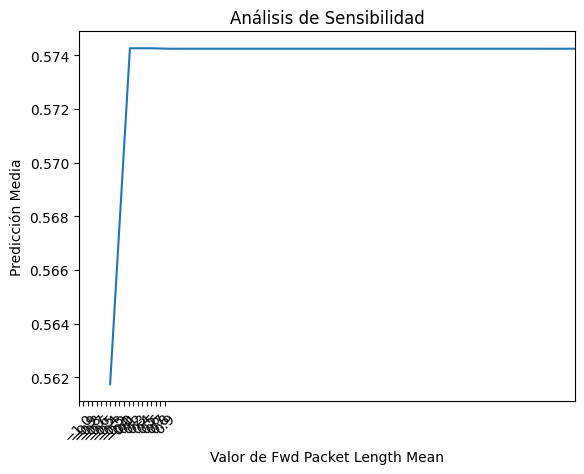

In [91]:
# Celda para ejecutar las distintas funciones, ya hay ejemplos de las últimas ejecuciones, si no en cada celda
# de cada función hay un ejemplo para cada modelo, basta con copiar y pegar aquí y si se quiere cambiar algún
# parametro como la característica, instancia etc.


#explicabilidad_global(logisticRegression_model_DDOS, top_20_feature_names) 
#dependencia_caracteristicas(mlp_model_DDOS, feature_idx=17) 
#analisis_residuos('logistic', X_test, y_test) 
#analisis_sensibilidad(xgBoost_model_PortScan, X_test, 1)
#analisis_influencia(svm_model_poly_degree_2PortScan,'poly2', X_test_df, y_test, slice(18000, 35500)) 
#permutacion_de_caracteristicas(xgBoost_model_PortScan, X_test, y_test_encoded, 1) 
#shap_valores_globales(svm_model_linearPortScan, 'svmLineal', top_20_feature_names) 
#shap_explicacion_local('xgBoost', X_test, 53, top_20_feature_names) 
#shap_valores_vs_reales('xgBoost', X_test_df, top_20_feature_names, 3) 
#lime_analisis_instancias(mlp_model_PortScan,'mlp', X_train, X_test, sample_index=2, feature_names=top_20_feature_names) 
#lime_analisis_caracteristicas('mlp', X_train, X_test, sample_index=2, feature_names=top_20_feature_names)
#lime_analisis_caracteristicasDispersion('logisticRegression', X_train, X_test, sample_index=2, feature_names=top_20_feature_names) 